### Retrieval Scoring + ranking


In [1]:
## Init stuff
import os
import json
import psycopg2
from openai import OpenAI
from dotenv import load_dotenv

load_dotenv()  # reads .env if present

REDDIT_CLIENT_ID = os.getenv("REDDIT_CLIENT_ID")
REDDIT_CLIENT_SECRET = os.getenv("REDDIT_CLIENT_SECRET")
REDDIT_USER_AGENT = os.getenv("REDDIT_USER_AGENT") or "knowledge-collection-service/0.1"

client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# --- connect to Postgres ---
conn = psycopg2.connect(
    host="localhost",
    port=5432,
    dbname="knowledgebase",
    user="stiw_user",
    password="stiw_pwd"
)
cursor = conn.cursor()
print("✅ Connected to Postgres and OpenAI")

✅ Connected to Postgres and OpenAI


Run once for Query & Query Embed, & test other systems for tweaks


In [ ]:
user_input = input("Enter your query or goal: ").strip()
print(f"Query: --> {user_input}")

# Running HyDE style query improvement 

HyDE_prompt = f"""
You are an extremely empathetic Reddit user writing a raw, honest submission asking for help.
Write a detailed (150–250 word) Reddit post (title + body) from someone in exactly the same situation as the user below.
Make it the kind of thoughtful, non-ranty, "I know I need to change, please help me" post that gets tons of supportive, practical, life-changing advice in the comments.

Query / situation: {user_input}

Start directly with the post (include a realistic title and then the body). 
Do NOT write advice or a success story — only the help-seeking post.
"""

print("Creating a HyDE hypothetical Reddit submission (OP post)...")
HyDE_response = client.chat.completions.create(
    model="gpt-4o-mini",       
    messages=[
        {"role": "system", "content": "You are a Reddit user asking for help in a detailed, vulnerable way."},
        {"role": "user", "content": HyDE_prompt}
    ],
    temperature=0.8, # keeps it varied and natural
    max_tokens=500 # Wanna limit token usage here to create precise embeddings
)

HyDE_answer = HyDE_response.choices[0].message.content.strip()

print("\📄 HyDE generated hypothetical Reddit submission \n")
print(HyDE_answer)

# Embedd HyDE, query
q_emb = client.embeddings.create(
        model="text-embedding-3-small",
        input=HyDE_answer
    ).data[0].embedding
print("✅ Query Embedding generated...")

In [ ]:
print(q_emb)

[0.048742491751909256, -0.02118801139295101, -0.014142117463052273, 0.06275878846645355, -0.006438815500587225, -0.017249859869480133, -0.0012353906640782952, 0.025251982733607292, 0.005092546343803406, 0.06280911713838577, -0.006781673524528742, -0.013802404515445232, -0.03920537233352661, 0.017614737153053284, 0.02851071022450924, -0.018055105581879616, -0.0037494224961847067, 0.07312632352113724, 0.011657181195914745, 0.05994043126702309, 0.04348323494195938, -0.012147877365350723, 0.0054857321083545685, 0.009203699417412281, -0.008159398101270199, -0.025793006643652916, 0.009172244928777218, -0.00124089524615556, -0.004809452220797539, 0.0076938653364777565, -0.021829690784215927, -0.03417259082198143, -0.04275348037481308, 0.005237238481640816, -0.01867162063717842, 0.0172876063734293, -0.04408716782927513, -0.02614530175924301, 0.08455073833465576, -0.015752607956528664, 0.03978414088487625, -0.022043583914637566, 0.06004108861088753, 0.01363883912563324, -0.020785389468073845, 0

Running through retrieved chunks for new scoring


In [ ]:
print("Retrieveing top matching submissions....")
cursor.execute("""
            SELECT 
                submission_id,
                domain_id,
                title, 
                selftext, 
                permalink, 
                (embedding <=> %s::vector) AS distance
            FROM submissions
            ORDER BY embedding <=> %s::vector
            LIMIT 15;
        """, (json.dumps(q_emb), json.dumps(q_emb)))
top_subs = cursor.fetchall()
top_subs = [subs for subs in top_subs if subs[5] < 0.45]
if not top_subs:
    print("❌ No Relevant submissions found")
else:
    print(f"✅ Found {len(top_subs)} relevant submissions")

# Printing submissions
print(json.dumps(top_subs, indent=5))

Retrieveing top matching submissions....
❌ No Relevant submissions found
[]


In [ ]:
# Collect related comments
context_blocks = []
sources = []  # track all permalinks for final output

top_submission_ids = [row[0] for row in top_subs]
print(top_submission_ids)


# Pulling in the most Relevant comments from only the top posts that we get
# There is also a small scoring boost for the high upvoted comments, at the time of querying
# Relevance first tho, only then popularity
query = """
WITH ranked_comments AS (
    SELECT 
        c.body,
        c.score,
        s.title,
        c.submission_id,
        s.permalink,
        c.embedding <=> %s::vector AS distance
    FROM comments c
    JOIN submissions s ON c.submission_id = s.submission_id
    WHERE c.submission_id = ANY(%s)
)
SELECT 
    body,
    score,
    title,
    submission_id,
    permalink,
    distance
FROM ranked_comments
ORDER BY 
    distance + (1.0 / (score + 10)) ASC 
LIMIT 20;
"""

# Note the order of parameters is now --> embedding, submission_ids list
cursor.execute(query, (json.dumps(q_emb), top_submission_ids))
relevant_comments = cursor.fetchall()

print(f"\n✅ Retrieved {len(relevant_comments)} relevant comments\n")

# for i, (body, score, title, permalink, distance) in enumerate(relevant_comments, 1):
#     print(f"{i:2d}. ↑{score}  (dist: {distance:.4f}) | {title}")
#     print(f"     {body.strip()[:900]}{'...' if len(body) > 900 else ''}")
#     print(f"     https://reddit.com{permalink}\n")
# print("="*120)

# Context map contains : submission_id -> {submission_info, comments}
context_map = {}

# building submission details
submission_details = {}
for sub in top_subs:
    submission_id = sub[0]
    title = sub[2]
    selftext = sub[3]
    permalink = sub[4]
    
    submission_details[submission_id] = {
        'title': title,
        'selftext': selftext,
        'permalink': permalink
    }


for comment in relevant_comments:
    body = comment[0]
    score = comment[1]
    title = comment[2]
    submission_id = comment[3]
    permalink = comment[4]
    distance = comment[5]
    
    if submission_id not in context_map:
        # Get selftext from submission_details
        sub_info = submission_details.get(submission_id, {})
        
        context_map[submission_id] = {
            'title': title,
            'permalink': permalink,
            'selftext': sub_info.get('selftext', ''),
            'comments': []
        }
    
    context_map[submission_id]['comments'].append({
        'body': body,
        'score': score,
        'distance': distance
    })

print(f"✅ Built context map with {len(context_map)} submissions\n")
print(json.dumps(context_map, indent=5))

['9hjn8y', 'a2dmje', '8hht7o', '93kcov', 'z9q8hm', '85tpgh', 'dl265l', '1kc67ha', '995lst', '1fitbc5', '631os1', 'juou3v', 'a8raia', '7nrqkz', '9t0gqz']

✅ Retrieved 20 relevant comments

✅ Built context map with 9 submissions

{
     "9hjn8y": {
          "title": "Everything I've Learned About Obesity is Right (and How I Used That To Lose 150lbs)",
          "permalink": "https://www.reddit.com/r/loseit/comments/9hjn8y/everything_ive_learned_about_obesity_is_right_and/",
          "selftext": "##How It Started\n\nThe date is June 30th, 2017. My name is Amanda and I weigh 331lbs. I just finished up an appointment at the gynecologist to get a mirena put in. My gynecologist, a sweet asian-american in her early 30s with a healthy body and kind face, tells me that the procedure is finished and I am good to go, but... \n\n\"Your blood pressure is awfully high, I am worried about you,\" she adds quickly. \"It was high last time, too. You should really see a doctor, there is one here, I can 

# Looking at more fetched comment details


In [ ]:
# Prepare for generation, 
context_blocks = []
sources = []

for submission_id, data in context_map.items():
    title = data['title']
    permalink = data['permalink']
    selftext = data['selftext']
    comments = data['comments']
    
    # Format comments
    joined_comments = "\n".join([
        f"- (↑{c['score']}) {c['body'][:600]}..." 
        for c in comments
    ])
    
    # Build block
    block = f"""
[POST] "{title}"
URL: {permalink}

{selftext[:1200] if selftext else "(No text body)"}

Top Comments:
{joined_comments}
"""
    context_blocks.append(block)
    sources.append(f"- {title}: {permalink}")

# Final context text to pass to LLM
context_text = "\n\n---\n\n".join(context_blocks)

print("CONTEXT FOR LLM:")
print(context_text)
print("\n" )
print("SOURCES:")
print("\n".join(sources))

CONTEXT FOR LLM:

[POST] "Everything I've Learned About Obesity is Right (and How I Used That To Lose 150lbs)"
URL: https://www.reddit.com/r/loseit/comments/9hjn8y/everything_ive_learned_about_obesity_is_right_and/

##How It Started

The date is June 30th, 2017. My name is Amanda and I weigh 331lbs. I just finished up an appointment at the gynecologist to get a mirena put in. My gynecologist, a sweet asian-american in her early 30s with a healthy body and kind face, tells me that the procedure is finished and I am good to go, but... 

"Your blood pressure is awfully high, I am worried about you," she adds quickly. "It was high last time, too. You should really see a doctor, there is one here, I can give you a recommendation. He's very business-oriented and scientific, you'll like him." 

Hesitantly, I agree. This is not the first time someone has spoken to me about my blood pressure, but it will be the first time I have visited a doctor in almost 8 years. 

Thyroid issues, blood pressu

### Step Extraction + K-Clustering


In [ ]:
all_steps = []
action_step_prompt = """
Extract actionable steps the user could take that are either:
• explicitly stated OR
• strongly implied by the comment

You may rewrite the steps in your own words BUT:
- Do NOT invent new ideas
- Do NOT give generic advice unrelated to the comment
- Keep each step specific and short (max 15 words)

Return ONLY:
{"steps": ["step 1", "step 2", ...]}

COMMENT:
"""

for sub_id, sub_data in context_map.items():
    print(f"\nDeriving Actionable steps for Submission -> {sub_data['title']} [{sub_id}]")

    for c in sub_data['comments']:
        comment_body = c["body"]
        score = c["score"]

        resp = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": "Extract only actionable steps, implied or explicit."},
                {"role": "user", "content": action_step_prompt + comment_body}
            ],
            temperature=0.1,
            max_tokens=150
        )

        raw = resp.choices[0].message.content
        print("RAW:\n", raw)

        try:
            # Strip markdown code blocks if present
            cleaned = raw.strip()
            if cleaned.startswith("```"):
                # Remove opening ```json or ```
                cleaned = cleaned.split('\n', 1)[1] if '\n' in cleaned else cleaned
                # Remove closing ```
                if cleaned.endswith("```"):
                    cleaned = cleaned.rsplit("```", 1)[0]
            
            cleaned = cleaned.strip()
            parsed = json.loads(cleaned)
            steps = parsed.get("steps", [])
        except Exception as e:
            print("JSON error:", e)
            steps = []
        
        for step_text in steps:
            emb = client.embeddings.create(
                model="text-embedding-3-small",
                input=step_text
            ).data[0].embedding

            all_steps.append({
                "step": step_text,
                "embedding": emb,
                "submission_id": sub_id,
                "permalink": sub_data['permalink'],
                "score": score
            })

print(f"TOTAL extracted steps: {len(all_steps)}")
for s in all_steps[:10]:
    print("•", s["step"])


Deriving Actionable steps for Submission -> Everything I've Learned About Obesity is Right (and How I Used That To Lose 150lbs) [9hjn8y]
RAW:
 {"steps": ["Continue tracking calorie intake under 1,700 daily.", "Stay committed to your weight loss goals.", "Ignore negative comments from others.", "Seek inspiration from positive role models."]}
RAW:
 {"steps": ["Continue eating nutritious foods that benefit your health.", "Aim to stay below your calorie goal.", "Don't stress about occasional calorie overages.", "Increase your physical activity regularly.", "Reflect on societal influences on your weight journey.", "Seek supportive environments at the gym.", "Engage with stories that resonate with your experiences."]}
RAW:
 {"steps": ["Sign up for the gym tomorrow.", "Focus on improving your diet.", "Aim to achieve a 6-pack.", "Strive for a body you desire."]}
RAW:
 {"steps": ["Seek out and read success stories for motivation.", "Take honest full body pictures for self-assessment.", "Acknow

Clusterning these for creating next action step summaries


In [ ]:
import numpy as np
from sklearn.cluster import HDBSCAN
from sklearn.metrics.pairwise import cosine_distances

# Convert to matrix of embeddings
X = np.array([s["embedding"] for s in all_steps])

# Use cosine distance instead of Euclidean
clusterer = HDBSCAN(
    metric="euclidean",
    min_cluster_size=4,
    min_samples=2,
    cluster_selection_epsilon=0.05
)

labels = clusterer.fit_predict(X)

# Attach cluster id to steps
for i, s in enumerate(all_steps):
    s["cluster"] = int(labels[i])

# Filter out noise (-1)
clusters = {}
for s in all_steps:
    cid = s["cluster"]
    if cid == -1:
        continue
    clusters.setdefault(cid, []).append(s)

print(f"🧩 Number of clusters: {len(clusters)}")
for cid, steps in clusters.items():
    print(f"\nCluster {cid} — {len(steps)} steps:")
    for s in steps[:5]:
        print("  •", s["step"])


🧩 Number of clusters: 2

Cluster 0 — 69 steps:
  • Continue tracking calorie intake under 1,700 daily.
  • Stay committed to your weight loss goals.
  • Ignore negative comments from others.
  • Seek inspiration from positive role models.
  • Continue eating nutritious foods that benefit your health.

Cluster 1 — 5 steps:
  • Organize your breakfast to improve workout consistency.
  • Set specific workout and eating goals.
  • Schedule regular social activities with friends.
  • Schedule consistent sleep times every day.
  • Establish a consistent sleep schedule.


Cluster visualization


c:\Software\Pitt\SWIT_LAB\knowledge-collection-service\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Software\Pitt\SWIT_LAB\knowledge-collection-service\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


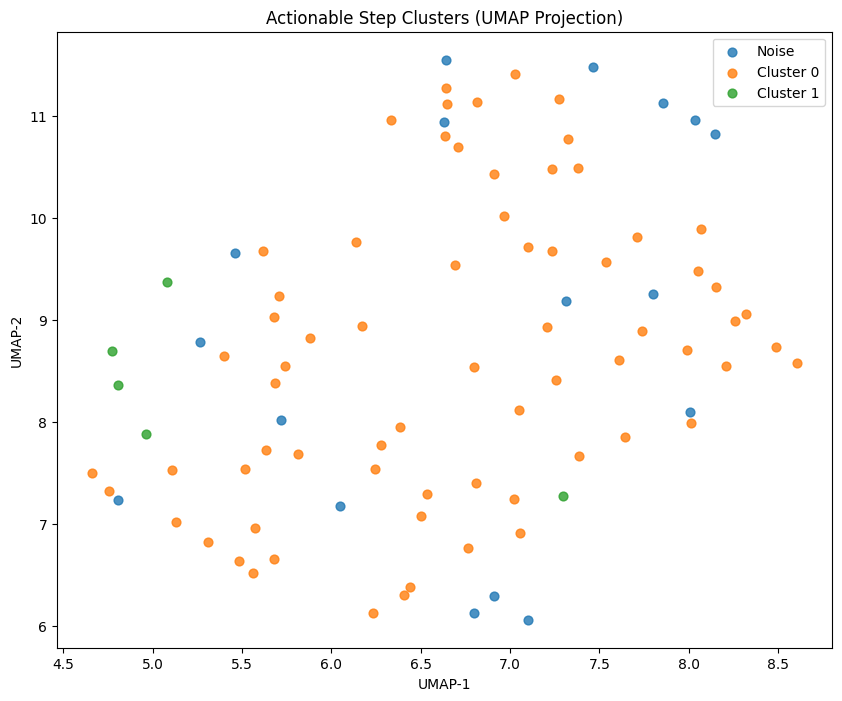

In [ ]:
import numpy as np
import umap.umap_ as umap
import matplotlib.pyplot as plt

# Extract embeddings + cluster labels
X = np.array([s["embedding"] for s in all_steps])
labels = np.array([s["cluster"] for s in all_steps])
steps_text = [s["step"] for s in all_steps]

# Project to 2D using UMAP (recommended for embeddings)
reducer = umap.UMAP(
    n_neighbors=12,
    min_dist=0.1,
    metric="cosine",
    random_state=42
)

embedding_2d = reducer.fit_transform(X)

# Plot
plt.figure(figsize=(10, 8))
unique_labels = sorted(set(labels))

for lab in unique_labels:
    mask = labels == lab
    label_name = f"Cluster {lab}" if lab != -1 else "Noise"
    plt.scatter(
        embedding_2d[mask, 0],
        embedding_2d[mask, 1],
        s=40,
        alpha=0.8,
        label=label_name
    )

plt.legend()
plt.title("Actionable Step Clusters (UMAP Projection)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()

In [ ]:
final_steps = []

for cluster in clusters:
    items = cluster["items"]
    combined_text = "\n".join([i["step"] for i in items])

    # Summarize cluster
    summary_resp = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "Summarize similar steps into one clean actionable step."},
            {"role": "user", "content": f"Combine these into one step:\n{combined_text}"}
        ],
        temperature=0.2,
        max_tokens=80
    )

    summary = summary_resp.choices[0].message.content.strip()

    # Compute relevance = avg distance to query embedding
    rel_scores = []
    for i in items:
        emb = np.array(i["embedding"])
        q = np.array(q_emb)
        rel = 1 - cosine(emb, q)
        rel_scores.append(float(rel))

    final_steps.append({
        "action_step": summary,
        "frequency": len(items),
        "avg_relevance": float(np.mean(rel_scores)),
        "sources": [
            {
                "submission_id": i["submission_id"],
                "url": i["permalink"],
                "score": i["score"],
                "original_step": i["step"]
            }
            for i in items
        ]
    })

# Sort higher frequency + higher relevance first
final_steps.sort(key=lambda x: (x["frequency"], -x["avg_relevance"]), reverse=True)


TypeError: 'int' object is not subscriptable

In [ ]:
print(json.dumps(final_steps, indent=5))

[
     {
          "action_step": "Consider how both societal attitudes and personal experiences have influenced your health journey.",
          "frequency": 1,
          "avg_relevance": 0.5991634682081795,
          "sources": [
               {
                    "submission_id": "9hjn8y",
                    "url": "https://www.reddit.com/r/loseit/comments/9hjn8y/everything_ive_learned_about_obesity_is_right_and/",
                    "score": 47,
                    "original_step": "Reflect on how societal attitudes and personal experiences have impacted your health journey."
               }
          ]
     },
     {
          "action_step": "Join a supportive community or connect with individuals who can aid in your personal growth.",
          "frequency": 1,
          "avg_relevance": 0.6077252256926182,
          "sources": [
               {
                    "submission_id": "z9q8hm",
                    "url": "https://www.reddit.com/r/getdisciplined/comments/z9q8hm/